# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 40

In [4]:
frames = range(5,25)
frames_to_sample = len(frames)
img_height = 160
img_width = 160
nb_classes=5

In [5]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(folder_list)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        num_rem_seqs = len(folder_list) - (num_batches*batch_size)
        if num_rem_seqs > 0:
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((num_rem_seqs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((num_rem_seqs,5)) # batch_labels is the one hot representation of the output
            rem_seqs = t[len(t)-num_rem_seqs:]
            for folder in range(num_rem_seqs): # iterate over the remaining sequences
                imgs = os.listdir(source_path+'/'+ rem_seqs[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ rem_seqs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                batch_labels[folder, int(rem_seqs[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

def define_model(filter_size=(2,2,2), dense_neurons=64, dropout=0.2):    

    model = Sequential()

    # Layer 1
    model.add(Conv3D(8,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 2
    model.add(Conv3D(16,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 3
    model.add(Conv3D(32,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 4
    model.add(Conv3D(64,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatter and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    #Output Softmax layer
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
conv3d1 = define_model()
optimiser = optimizers.Adam(lr=0.001)
conv3d1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 8)   200       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 16)    1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 40, 40, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 5, 40, 40, 32)     4128      
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = conv3d1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - 169s 10s/step - loss: 1.2935 - categorical_accuracy: 0.4974 - val_loss: 1.3299 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2021-02-0314_21_26.367312/model-00001-1.30209-0.49472-1.32991-0.55000.h5
Epoch 2/10
17/17 [==============================] - 69s 4s/step - loss: 0.5499 - categorical_accuracy: 0.7991 - val_loss: 0.9829 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2021-02-0314_21_26.367312/model-00002-0.55460-0.79638-0.98291-0.66000.h5
Epoch 3/10
17/17 [==============================] - 70s 4s/step - loss: 0.3126 - categorical_accuracy: 0.9036 - val_loss: 0.9107 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-02-0314_21_26.367312/model-00003-0.31066-0.90649-0.91066-0.65000.h5
Epoch 4/10
17/17 [==============================] - 71s 4s

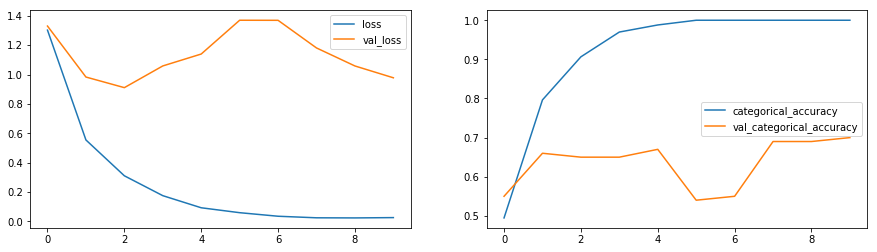

In [14]:
plot(history)

The model is overfitting on the train data.

Let us do Data Augmentation.

In [15]:
import cv2

def augmented_generator(source_path, folder_list, batch_size, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(folder_list)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            if augment:
                batch_data_aug = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                    if augment:
                        M = np.float32([[1,0,np.random.randint(-20,20)],[0,1,np.random.randint(-20,20)]])
                        rows,cols = image.shape[0],image.shape[1]
                        
                        shifted_image = cv2.warpAffine(image, M, (cols,rows))
                        
                        rot_matrix = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),5,1)
                        rotated_image = cv2.warpAffine(image, rot_matrix, (cols,rows))
                        
                        rot_norm_image = (rotated_image - np.mean(rotated_image))/(np.max(rotated_image) - np.min(rotated_image))
                        
                        batch_data_aug[folder,idx,:,:,0] = rot_norm_image[:,:,0]
                        batch_data_aug[folder,idx,:,:,1] = rot_norm_image[:,:,1]
                        batch_data_aug[folder,idx,:,:,2] = rot_norm_image[:,:,2]
                        
                        
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if augment:
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        num_rem_seqs = len(folder_list) - (num_batches*batch_size)
        if num_rem_seqs > 0:
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((num_rem_seqs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((num_rem_seqs,5)) # batch_labels is the one hot representation of the output
            if augment:
                batch_data_aug = np.zeros((num_rem_seqs,x,y,z,3))
            rem_seqs = t[len(t)-num_rem_seqs:]
            for folder in range(num_rem_seqs): # iterate over the remaining sequences
                imgs = os.listdir(source_path+'/'+ rem_seqs[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ rem_seqs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                    if augment:
                        M = np.float32([[1,0,np.random.randint(-20,20)],[0,1,np.random.randint(-20,20)]])
                        rows,cols = image.shape[0],image.shape[1]
                        
                        shifted_image = cv2.warpAffine(image, M, (cols,rows))
                        
                        rot_matrix = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),5,1)
                        rotated_image = cv2.warpAffine(image, rot_matrix, (cols,rows))
                        
                        rot_norm_image = (rotated_image - np.mean(rotated_image))/(np.max(rotated_image) - np.min(rotated_image))
                        
                        batch_data_aug[folder,idx,:,:,0] = rot_norm_image[:,:,0]
                        batch_data_aug[folder,idx,:,:,1] = rot_norm_image[:,:,1]
                        batch_data_aug[folder,idx,:,:,2] = rot_norm_image[:,:,2]
                    
                batch_labels[folder, int(rem_seqs[folder].strip().split(';')[2])] = 1
            
            if augment:
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [16]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


### Create a new Conv3D model

We keep the image size same as 160,160

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

def define_second_model(filter_size=(2,2,2), dense_neurons=128, dropout=0.2, include_last=True):    

    model = Sequential()

    # Layer 1
    model.add(Conv3D(8,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 2
    model.add(Conv3D(16,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 3
    model.add(Conv3D(32,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 4
    model.add(Conv3D(64,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    if include_last:        
        # Layer 5
        model.add(Conv3D(128,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

    # Flatter and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    #Output Softmax layer
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [18]:
# print summary of model 2

conv3d2 = define_second_model()
optimiser = optimizers.Adam(lr=0.001)
conv3d2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 8)   200       
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 16)    1040      
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 5, 40, 40, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 5, 40, 40, 32)     4128      
__________

In [19]:
# generators
second_train_generator = augmented_generator(train_path, train_doc, batch_size, augment=True)
second_val_generator = augmented_generator(val_path, val_doc, batch_size)

In [20]:
# len(second_train_generator)

In [21]:
# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [22]:
# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
history_conv3d2 = conv3d2.fit_generator(second_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=second_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - 108s 6s/step - loss: 1.2352 - categorical_accuracy: 0.5700 - val_loss: 1.4630 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2021-02-0314_34_33.169710/model-00001-1.23356-0.57014-1.46304-0.62000.h5
Epoch 2/10
17/17 [==============================] - 96s 6s/step - loss: 0.4209 - categorical_accuracy: 0.8516 - val_loss: 0.9184 - val_categorical_accuracy: 0.7300

Epoch 00002: saving model to model_init_2021-02-0314_34_33.169710/model-00002-0.42326-0.85068-0.91842-0.73000.h5
Epoch 3/10
17/17 [==============================] - 98s 6s/step - loss: 0.2122 - categorical_accuracy: 0.9292 - val_loss: 0.8709 - val_categorical_accuracy: 0.7600

Epoch 00003: saving model to model_init_2021-02-0314_34_33.169710/model-00003-0.21186-0.92911-0.87090-0.76000.h5
Epoch 4/10
17/17 [==============================] - 98s 6s/

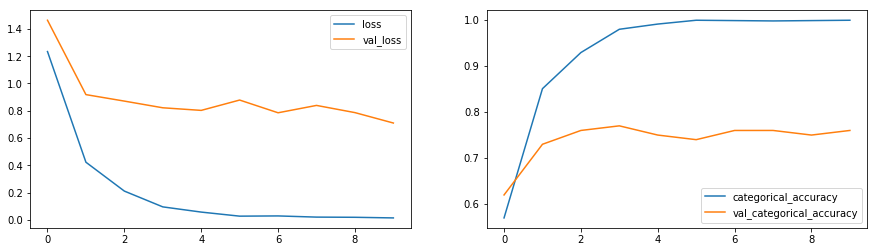

In [24]:
plot(history_conv3d2)

Here again, the model is overfitting on the train data, but the validation accuracy is improved to ~76%.

Let us increase the filter size to (3,3,3) and rerun the model.

In [25]:
# print summary of model 3

conv3d3 = define_second_model(filter_size=(3,3,3))
optimiser = optimizers.Adam(lr=0.001)
conv3d3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 20, 160, 160, 8)   656       
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 10, 80, 80, 8)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 10, 80, 80, 16)    3472      
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 5, 40, 40, 16)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 5, 40, 40, 32)     13856     
__________

In [26]:
# generators
second_train_generator = augmented_generator(train_path, train_doc, batch_size, augment=True)
second_val_generator = augmented_generator(val_path, val_doc, batch_size)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
# run the model
history_conv3d3 = conv3d3.fit_generator(second_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=second_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - 113s 7s/step - loss: 1.4969 - categorical_accuracy: 0.4537 - val_loss: 3.8786 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2021-02-0314_34_33.169710/model-00001-1.49285-0.45626-3.87862-0.37000.h5
Epoch 2/10
17/17 [==============================] - 94s 6s/step - loss: 0.7537 - categorical_accuracy: 0.7075 - val_loss: 1.6425 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2021-02-0314_34_33.169710/model-00002-0.75836-0.70513-1.64252-0.59000.h5
Epoch 3/10
17/17 [==============================] - 98s 6s/step - loss: 0.4147 - categorical_accuracy: 0.8466 - val_loss: 1.0450 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2021-02-0314_34_33.169710/model-00003-0.41326-0.84766-1.04504-0.72000.h5
Epoch 4/10
17/17 [==============================] - 98s 6s/

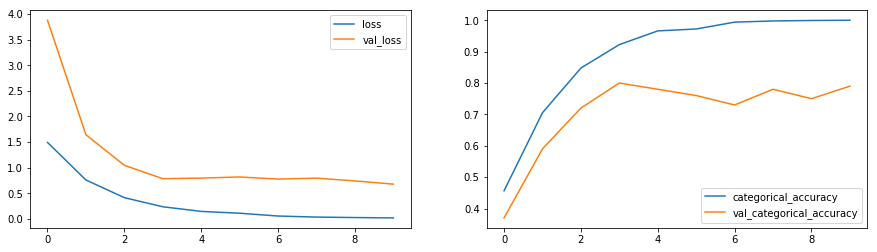

In [28]:
plot(history_conv3d3)

### Build a model without last layer of 128 neurons

In [29]:
# print summary of model 4

conv3d4 = define_second_model(filter_size=(3,3,3), include_last=False)
optimiser = optimizers.Adam(lr=0.001)
conv3d4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 20, 160, 160, 8)   656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 80, 80, 8)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 10, 80, 80, 16)    3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 5, 40, 40, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 40, 40, 32)     13856     
__________

In [30]:
# generators
second_train_generator = augmented_generator(train_path, train_doc, batch_size, augment=True)
second_val_generator = augmented_generator(val_path, val_doc, batch_size)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
# run the model
history_conv3d4 = conv3d4.fit_generator(second_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=second_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - 106s 6s/step - loss: 1.4078 - categorical_accuracy: 0.4902 - val_loss: 2.0640 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2021-02-0314_34_33.169710/model-00001-1.41609-0.48944-2.06404-0.49000.h5
Epoch 2/10
17/17 [==============================] - 95s 6s/step - loss: 0.5261 - categorical_accuracy: 0.8074 - val_loss: 1.7404 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2021-02-0314_34_33.169710/model-00002-0.52795-0.80694-1.74037-0.50000.h5
Epoch 3/10
17/17 [==============================] - 96s 6s/step - loss: 0.2975 - categorical_accuracy: 0.9007 - val_loss: 1.0637 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2021-02-0314_34_33.169710/model-00003-0.30039-0.90045-1.06374-0.64000.h5
Epoch 4/10
17/17 [==============================] - 97s 6s/

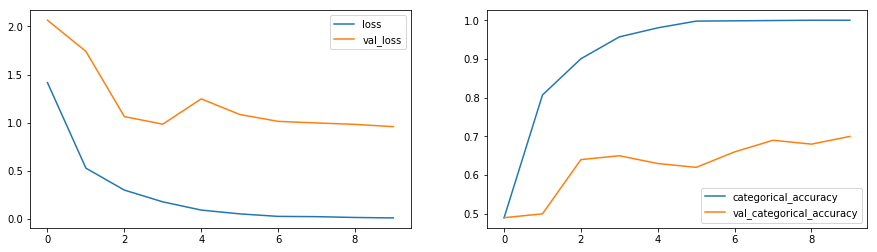

In [32]:
plot(history_conv3d4)

### Build a new model with less layers and different filter sizes

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

def define_third_model(filter_size=(3,3,3), dense_neurons=128, dropout=0.2):    

    model = Sequential()

    # Layer 1
    model.add(Conv3D(8,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 2
    model.add(Conv3D(16,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 3
    model.add(Conv3D(32,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Layer 4
    model.add(Conv3D(64,filter_size,padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))
    
    # Layer 5
    model.add(Conv3D(128,(2,2,2),padding='same',input_shape=(frames_to_sample, img_height, img_width, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    
    # Flatter and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    #Output Softmax layer
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [34]:
# print summary of model 5
# reducing the learning rate as the model is overfitting the train data

conv3d5 = define_third_model(filter_size=(3,3,3))
optimiser = optimizers.Adam(lr=0.0002)
conv3d5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 20, 160, 160, 8)   656       
_________________________________________________________________
batch_normalization_23 (Batc (None, 20, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 10, 80, 80, 8)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 10, 80, 80, 16)    3472      
_________________________________________________________________
batch_normalization_24 (Batc (None, 10, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 5, 40, 40, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 5, 40, 40, 32)     13856     
__________

In [35]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [36]:
# generators
second_train_generator = augmented_generator(train_path, train_doc, 40, augment=True)
second_val_generator = augmented_generator(val_path, val_doc, 40)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
# run the model
history_conv3d5 = conv3d5.fit_generator(second_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=second_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - 109s 6s/step - loss: 2.3696 - categorical_accuracy: 0.2676 - val_loss: 1.5276 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2021-02-0315_24_33.569910/model-00001-2.37652-0.26621-1.52759-0.43000.h5
Epoch 2/20
17/17 [==============================] - 96s 6s/step - loss: 1.6656 - categorical_accuracy: 0.4385 - val_loss: 1.1658 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2021-02-0315_24_33.569910/model-00002-1.66541-0.43967-1.16581-0.50000.h5
Epoch 3/20
17/17 [==============================] - 101s 6s/step - loss: 1.4449 - categorical_accuracy: 0.4950 - val_loss: 1.0383 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2021-02-0315_24_33.569910/model-00003-1.43340-0.49698-1.03827-0.61000.h5
Epoch 4/20
17/17 [==============================] - 100s 6

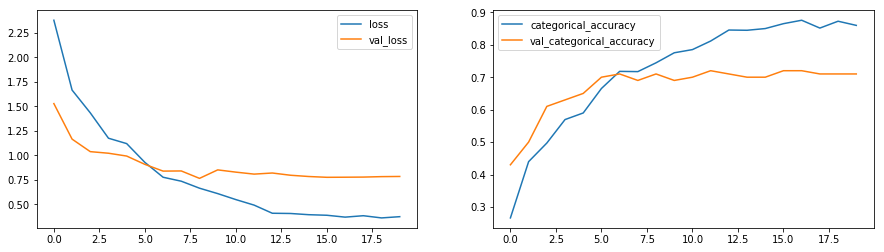

In [38]:
plot(history_conv3d5)

#### Thus with Conv3D model we were able to achieve 72% of accuracy on validation data set with data augmentation

### CNN + RNN Model with GRU

In [39]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 32

In [40]:
frames = range(5,25)
frames_to_sample = len(frames)
img_height = 100
img_width = 100
nb_classes=5

In [41]:
def rnn_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(folder_list)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        num_rem_seqs = len(folder_list) - (num_batches*batch_size)
        if num_rem_seqs > 0:
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((num_rem_seqs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((num_rem_seqs,5)) # batch_labels is the one hot representation of the output
            rem_seqs = t[len(t)-num_rem_seqs:]
            for folder in range(num_rem_seqs): # iterate over the remaining sequences
                imgs = os.listdir(source_path+'/'+ rem_seqs[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ rem_seqs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                batch_labels[folder, int(rem_seqs[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [42]:
from keras.applications import vgg16, resnet50, mobilenet
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [43]:
def cnn_rnn_model_1(gru_cells=64, dense_neurons=64, dropout=0.25):
    
    vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))
    
    model = Sequential()
    
    model.add(TimeDistributed(vgg_model, input_shape=(frames_to_sample, img_height, img_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    for layer in vgg_model.layers:
        layer.trainable=False
    
    model.add(GRU(gru_cells, use_bias=False))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [44]:
cnn_rnn_1 = cnn_rnn_model_1()
optimiser = optimizers.Adam()
cnn_rnn_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(cnn_rnn_1.summary())

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 512)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                110592    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (

In [45]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [46]:
# generators
rnn_train_generator = rnn_generator(train_path, train_doc, batch_size)
rnn_val_generator = rnn_generator(val_path, val_doc, batch_size)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [47]:
# run the model
history_cnn_rnn_1 = cnn_rnn_1.fit_generator(rnn_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=rnn_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - 70s 3s/step - loss: 1.6511 - categorical_accuracy: 0.2520 - val_loss: 1.5128 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2021-02-0315_57_59.424174/model-00001-1.65063-0.25189-1.51282-0.34000.h5
Epoch 2/15
21/21 [==============================] - 44s 2s/step - loss: 1.4664 - categorical_accuracy: 0.3756 - val_loss: 1.3652 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2021-02-0315_57_59.424174/model-00002-1.46470-0.37707-1.36517-0.52000.h5
Epoch 3/15
21/21 [==============================] - 55s 3s/step - loss: 1.3365 - categorical_accuracy: 0.4456 - val_loss: 1.2626 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2021-02-0315_57_59.424174/model-00003-1.33978-0.44344-1.26255-0.57000.h5
Epoch 4/15
21/21 [==============================] - 55s 3s/s

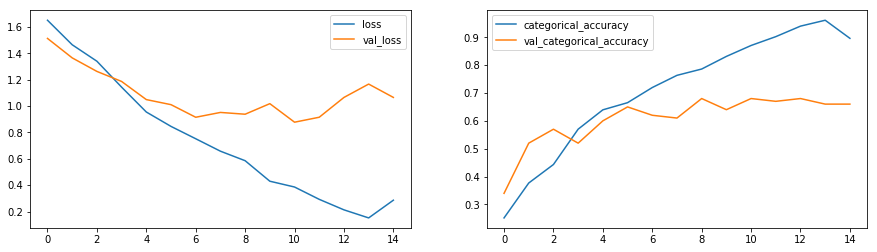

In [48]:
plot(history_cnn_rnn_1)

The trainind accuracy and validation accuracy are having huge difference.

Let us try another transfer learning model

In [49]:
def cnn_rnn_model_2(gru_cells=64, dense_neurons=64, dropout=0.25):
    
    mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))
    
    model = Sequential()
    
    model.add(TimeDistributed(mobilenet_model, input_shape=(frames_to_sample, img_height, img_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    for layer in mobilenet_model.layers:
        layer.trainable=False
    
    model.add(GRU(gru_cells, use_bias=False))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [50]:
frames = range(5,25)
frames_to_sample = len(frames)
img_height = 128
img_width = 128
nb_classes=5

cnn_rnn_2 = cnn_rnn_model_2(dense_neurons=128, gru_cells=128)
optimiser = optimizers.Adam()
cnn_rnn_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(cnn_rnn_2.summary())

17227776/17225924 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 20, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 4096)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               1622016   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_11 

In [51]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [52]:
# generators
rnn_train_generator = rnn_generator(train_path, train_doc, batch_size)
rnn_val_generator = rnn_generator(val_path, val_doc, batch_size)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
# run the model
history_cnn_rnn_2 = cnn_rnn_2.fit_generator(rnn_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=rnn_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 67s 3s/step - loss: 1.6357 - categorical_accuracy: 0.3036 - val_loss: 1.3476 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2021-02-0316_11_52.534585/model-00001-1.63612-0.30468-1.34756-0.49000.h5
Epoch 2/10
21/21 [==============================] - 54s 3s/step - loss: 1.2590 - categorical_accuracy: 0.4878 - val_loss: 1.0123 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2021-02-0316_11_52.534585/model-00002-1.26277-0.48567-1.01231-0.60000.h5
Epoch 3/10
21/21 [==============================] - 58s 3s/step - loss: 0.9576 - categorical_accuracy: 0.6313 - val_loss: 0.8125 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2021-02-0316_11_52.534585/model-00003-0.95925-0.63047-0.81246-0.69000.h5
Epoch 4/10
21/21 [==============================] - 58s 3s/s

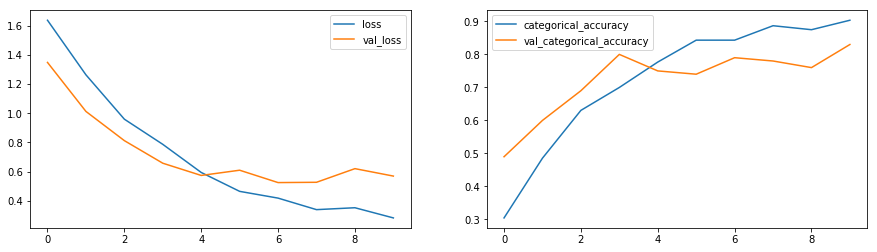

In [54]:
plot(history_cnn_rnn_2)

### We have got the best accuracy of ~83% on validation data.

### Let us augment the data and re run the models

In [55]:
import cv2

def rnn_augmented_generator(source_path, folder_list, batch_size, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(folder_list)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            if augment:
                batch_data_aug = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                    if augment:
                        M = np.float32([[1,0,np.random.randint(-20,20)],[0,1,np.random.randint(-20,20)]])
                        rows,cols = image.shape[0],image.shape[1]
                        
                        shifted_image = cv2.warpAffine(image, M, (cols,rows))
                        
                        rot_matrix = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),5,1)
                        rotated_image = cv2.warpAffine(image, rot_matrix, (cols,rows))
                        
                        rot_norm_image = (rotated_image - np.mean(rotated_image))/(np.max(rotated_image) - np.min(rotated_image))
                        
                        batch_data_aug[folder,idx,:,:,0] = rot_norm_image[:,:,0]
                        batch_data_aug[folder,idx,:,:,1] = rot_norm_image[:,:,1]
                        batch_data_aug[folder,idx,:,:,2] = rot_norm_image[:,:,2]
                        
                        
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if augment:
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        num_rem_seqs = len(folder_list) - (num_batches*batch_size)
        if num_rem_seqs > 0:
            x = len(img_idx)
            y = img_height
            z = img_width
            batch_data = np.zeros((num_rem_seqs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((num_rem_seqs,5)) # batch_labels is the one hot representation of the output
            if augment:
                batch_data_aug = np.zeros((num_rem_seqs,x,y,z,3))
            rem_seqs = t[len(t)-num_rem_seqs:]
            for folder in range(num_rem_seqs): # iterate over the remaining sequences
                imgs = os.listdir(source_path+'/'+ rem_seqs[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ rem_seqs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(y,z,3))
                    
                    norm_image = (image - np.mean(image))/(np.max(image) - np.min(image))
                    
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]
                    
                    if augment:
                        M = np.float32([[1,0,np.random.randint(-20,20)],[0,1,np.random.randint(-20,20)]])
                        rows,cols = image.shape[0],image.shape[1]
                        
                        shifted_image = cv2.warpAffine(image, M, (cols,rows))
                        
                        rot_matrix = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),5,1)
                        rotated_image = cv2.warpAffine(image, rot_matrix, (cols,rows))
                        
                        rot_norm_image = (rotated_image - np.mean(rotated_image))/(np.max(rotated_image) - np.min(rotated_image))
                        
                        batch_data_aug[folder,idx,:,:,0] = rot_norm_image[:,:,0]
                        batch_data_aug[folder,idx,:,:,1] = rot_norm_image[:,:,1]
                        batch_data_aug[folder,idx,:,:,2] = rot_norm_image[:,:,2]
                    
                batch_labels[folder, int(rem_seqs[folder].strip().split(';')[2])] = 1
            
            if augment:
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [56]:
def cnn_rnn_model_3(gru_cells=64, dense_neurons=64, dropout=0.25):
    
    vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))
    
    model = Sequential()
    
    model.add(TimeDistributed(vgg_model, input_shape=(frames_to_sample, img_height, img_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(dropout))
    
    for layer in vgg_model.layers:
        layer.trainable=False
    
    model.add(GRU(gru_cells, use_bias=False))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [57]:
frames = range(5,25)
frames_to_sample = len(frames)
img_height = 100
img_width = 100
nb_classes=5

cnn_rnn_3 = cnn_rnn_model_3(dense_neurons=128, gru_cells=128)
optimiser = optimizers.Adam()
cnn_rnn_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(cnn_rnn_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 20, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 512)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 512)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               245760    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
__________

In [58]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [59]:
# generators
rnn_train_generator = rnn_augmented_generator(train_path, train_doc, batch_size)
rnn_val_generator = rnn_augmented_generator(val_path, val_doc, batch_size)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
# run the model
history_cnn_rnn_3 = cnn_rnn_3.fit_generator(rnn_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=rnn_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - 64s 3s/step - loss: 1.6353 - categorical_accuracy: 0.2509 - val_loss: 1.5226 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2021-02-0316_21_39.927253/model-00001-1.63509-0.25189-1.52264-0.25000.h5
Epoch 2/15
21/21 [==============================] - 51s 2s/step - loss: 1.4456 - categorical_accuracy: 0.3644 - val_loss: 1.3491 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2021-02-0316_21_39.927253/model-00002-1.44781-0.36350-1.34909-0.46000.h5
Epoch 3/15
21/21 [==============================] - 54s 3s/step - loss: 1.2494 - categorical_accuracy: 0.4746 - val_loss: 1.2149 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2021-02-0316_21_39.927253/model-00003-1.24650-0.47511-1.21487-0.52000.h5
Epoch 4/15
21/21 [==============================] - 53s 3s/s

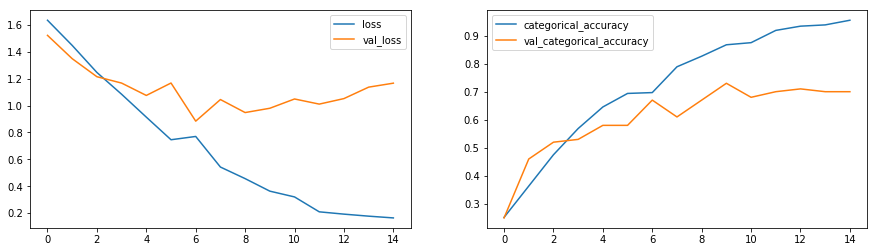

In [61]:
plot(history_cnn_rnn_3)

### We got the best model with 70% validation accuracy. Here we can see that the model is not overfitting on the training data. 


### Let us run mobile net model on the augmented data set

In [62]:
def cnn_rnn_model_4(gru_cells=64, dense_neurons=64, dropout=0.25):
    
    mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))
    
    model = Sequential()
    
    model.add(TimeDistributed(mobilenet_model, input_shape=(frames_to_sample, img_height, img_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    for layer in mobilenet_model.layers:
        layer.trainable=False
    
    model.add(GRU(gru_cells, use_bias=False))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [63]:
frames = range(5,25)
frames_to_sample = len(frames)
img_height = 128
img_width = 128
nb_classes=5

cnn_rnn_4 = cnn_rnn_model_4(dense_neurons=128, gru_cells=128)
optimiser = optimizers.Adam()
cnn_rnn_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(cnn_rnn_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 20, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 20, 4096)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               1622016   
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

In [64]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [65]:
# generators
rnn_train_generator = rnn_augmented_generator(train_path, train_doc, batch_size)
rnn_val_generator = rnn_augmented_generator(val_path, val_doc, batch_size)


# Model checkpoints and saving
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]


# steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [66]:
# run the model
history_cnn_rnn_4 = cnn_rnn_4.fit_generator(rnn_train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=rnn_val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ./Project_data/train ; batch size = Epoch 1/1532

 ./Project_data/val ; batch size = 32
21/21 [==============================] - 65s 3s/step - loss: 1.6619 - categorical_accuracy: 0.2656 - val_loss: 1.3320 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2021-02-0316_35_38.209168/model-00001-1.66445-0.26395-1.33203-0.50000.h5
Epoch 2/15
21/21 [==============================] - 54s 3s/step - loss: 1.4175 - categorical_accuracy: 0.3953 - val_loss: 1.1253 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2021-02-0316_35_38.209168/model-00002-1.41907-0.39367-1.12526-0.61000.h5
Epoch 3/15
21/21 [==============================] - 58s 3s/step - loss: 1.1359 - categorical_accuracy: 0.5373 - val_loss: 1.0092 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2021-02-0316_35_38.209168/model-00003-1.13752-0.53695-1.00919-0.60000.h5
Epoch 4/15
21/21 [==============================] - 58s 3s/s

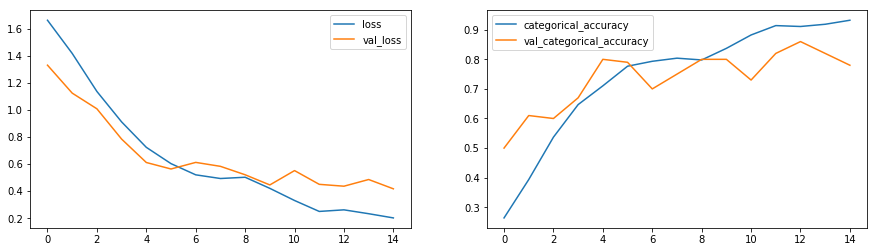

In [67]:
plot(history_cnn_rnn_4)

### We got the best model with:
- ### Train Accuracy: ~91.10%.
- ### Validation Accuracy: 86.00%.

### Model: model-00013-0.26162-0.91101-0.43656-0.86000.h5